# Optimization Homework 3
Here are just some simple codes for the homework.
I follow [Numerical Recipes in C](https://www.cec.uchile.cl/cinetica/pcordero/MC_libros/NumericalRecipesinC.pdf)
for the overall algorithm.

For the first part of the problem we find the linear approximation of this set of points.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # For comparision

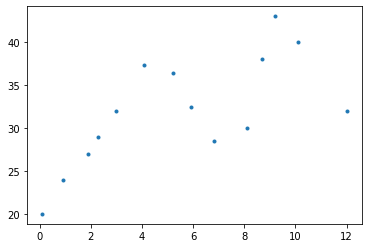

In [34]:
X = np.array([0.1, 0.9, 1.9, 2.3, 3, 4.1, 5.2, 5.9, 6.8, 8.1,
    8.7, 9.2, 10.1, 12])
Y = np.array([20, 24, 27, 29, 32, 37.3, 36.4, 32.4, 28.5,
             30, 38, 43, 40, 32])
plt.plot(X, Y, '.')

# Variance
In the book they assume that each point has its own variance $\sigma_i$, but here we just use the same $\sigma$ for all the points.

The terms of the formula are:
$$ S = \sum_{i=1}^{N}\frac{1}{\sigma^2_i}\quad S_x=\sum_{i=1}^{N}\frac{x_i}{\sigma^2_i} \quad S_y = \sum_{i=1}^{N}\frac{y_i}{\sigma_i^2}$$
$$S_{xx} = \sum_{i=1}^{N}\frac{x_i^2}{\sigma_i^2}\quad S_{xy}=\sum_{i=1}^{N}\frac{x_i y_i}{\sigma_i^2}$$

In [68]:
def optimize(X, Y):
    m, b = 0, 0
    npoints = X.shape[0]
    iterations = 5
    lr = 0.01
    i = 0
    while i < iterations:
        preds = X * m + b
        dm =(-2/npoints)* np.sum(X * (Y - preds))
        db = (-2/npoints)*(np.sum(Y - preds))
        m -= (dm * lr)
        b -= (db * lr)
        
        i += 1
    return m, b

## Plot the Estimate Line
Initial estimate given arbitrary variance.

4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394


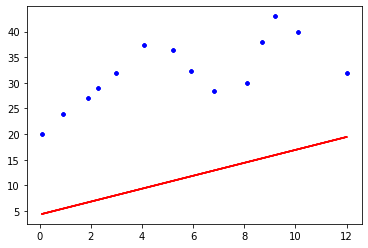

In [70]:
i = 0
while i < 5:
    a, b = optimize(X, Y)
    print(a,b)
    preds = X * b + a
    var = np.sum(np.power(Y - preds, 2) / (N - M)) 
    #print(var)
    plt.plot(X, Y, 'b.')
    plt.plot(X, preds, 'r')
    i += 1
plt.show()

## `sklearn`'s Linear Regression for comparison

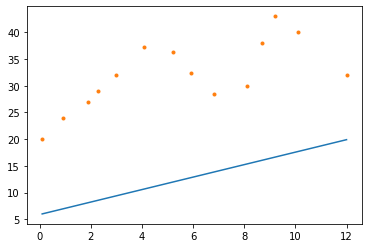

In [55]:
model  = LinearRegression().fit(X.reshape(-1, 1), Y)
plt.plot(X, X * model.coef_ + b)
plt.plot(X, Y, '.')
plt.show()
